In [1]:
import sys

In [2]:
sys.executable

'/home/nicolasf/anaconda3/envs/autogluon-gpu/bin/python'

In [3]:
# Parameters 

application = 'Innovation_Vineyards'
varname = 'TMEAN_N'
stat = 'mean'
num_quantiles = 3
target_type = f'cat{num_quantiles}'
step = 4
lag_sst = True
max_lag = 6
detrend_sst = False

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
%matplotlib inline

In [8]:
import pathlib

In [9]:
import matplotlib.pyplot as plt 

In [10]:
import numpy as np 
import pandas as pd 
import xarray as xr
from scipy.signal import detrend

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

In [13]:
import autogluon as ag
from autogluon import TabularPrediction as task

In [14]:
np.random.seed(42)

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd()

### read the target variable 

In [16]:
ipath_target = pathlib.Path(HOME.joinpath(f"research/Smart_Ideas/outputs/targets/application_cases/{application}/SEASONAL/{varname}"))

In [17]:
target = pd.read_csv(ipath_target.joinpath(f"Seasonal_{varname}_{stat}_anomalies_and_Q{num_quantiles}_categories.csv"), index_col=0, parse_dates=True)

In [18]:
target = target.loc[:,[target_type]]

### keep only data post 1981 to enable direct comparison with GCM derived fields 

In [19]:
target = target.loc['1981':,:]

### reads the SSTs, seasonal anomalies, pre-computed 

In [20]:
ipath_sst = pathlib.Path(HOME.joinpath("/media/nicolasf/END19101/data/ERSST/processed"))

In [21]:
lfiles_sst = list(ipath_sst.glob("*.nc")) 

In [22]:
lfiles_sst.sort() 

In [23]:
lfiles_sst[0]

PosixPath('/media/nicolasf/END19101/data/ERSST/processed/ERSST_seasonal_anomalies_1979-03.nc')

In [24]:
lfiles_sst[-1]

PosixPath('/media/nicolasf/END19101/data/ERSST/processed/ERSST_seasonal_anomalies_2020-03.nc')

In [25]:
dset_sst = xr.open_mfdataset(lfiles_sst, concat_dim='time')

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-p

In [26]:
dset_sst

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 493)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1979-03-31 1979-04-30 ... 2020-03-31
    month    (time) int64 3 4 5 6 7 8 9 10 11 12 1 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>

In [27]:
dset_sst = dset_sst.sel(time=slice('1981',None))

### domain selection 

In [28]:
domain_def = {}
domain_def['HB_seasonal'] = [120, 290, -60, 40]
domain_def['local'] = [150, 200, -50, -10]
domain_def['regional'] = [90, 300, -65, 50]
domain_def['ext_regional'] = [70, 300, -70, 60]
domain_def['global'] = [0, 360, -70, 70]
domain_def['tropics'] = [0, 360, -40, 40]

In [29]:
domain = 'HB_seasonal'

##### initial 

In [30]:
# dset_sst = dset_sst.sel(lat=slice(-60, 40), lon=slice(120, 290)) 

##### extended 

In [31]:
# dset_sst = dset_sst.sel(lat=slice(-70, 70)) 

##### local

In [32]:
dset_sst = dset_sst.sel(lat=slice(*domain_def[domain][2:]), lon=slice(*domain_def[domain][:2])) 

In [34]:
dset_sst

<xarray.Dataset>
Dimensions:  (lat: 51, lon: 86, time: 471)
Coordinates:
  * lat      (lat) float64 -60.0 -58.0 -56.0 -54.0 -52.0 ... 34.0 36.0 38.0 40.0
  * lon      (lon) float64 120.0 122.0 124.0 126.0 ... 284.0 286.0 288.0 290.0
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2020-03-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 51, 86), meta=np.ndarray>

### shift the time index in order to align the observed SST at time m - 4 with the observed rainfall at time 0, e.g. OND SST --> FMA precip 

In [35]:
dset_sst_shift = dset_sst.copy()

In [36]:
dset_sst_shift = dset_sst.shift(time=step)

### remove the first `step` seasons which are missing 

In [37]:
dset_sst_shift = dset_sst_shift.isel(time=slice(step, None))

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
dset_sst_shift = dset_sst_shift.stack(s=('lat','lon'))

In [39]:
dset_sst_shift

<xarray.Dataset>
Dimensions:  (s: 4386, time: 467)
Coordinates:
  * time     (time) datetime64[ns] 1981-05-31 1981-06-30 ... 2020-03-31
    month    (time) int64 5 6 7 8 9 10 11 12 1 2 3 ... 5 6 7 8 9 10 11 12 1 2 3
  * s        (s) MultiIndex
  - lat      (s) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ... 40.0 40.0 40.0 40.0
  - lon      (s) float64 120.0 122.0 124.0 126.0 ... 284.0 286.0 288.0 290.0
Data variables:
    sst      (time, s) float32 dask.array<chunksize=(1, 4386), meta=np.ndarray>

### drop the land points 

In [40]:
dset_sst_shift = dset_sst_shift.dropna('s')

In [41]:
dset_sst_shift.load()

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:  (s: 3981, time: 467)
Coordinates:
  * time     (time) datetime64[ns] 1981-05-31 1981-06-30 ... 2020-03-31
    month    (time) int64 5 6 7 8 9 10 11 12 1 2 3 ... 5 6 7 8 9 10 11 12 1 2 3
  * s        (s) MultiIndex
  - lat      (s) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ... 40.0 40.0 40.0 40.0
  - lon      (s) float64 120.0 122.0 124.0 126.0 ... 284.0 286.0 288.0 290.0
Data variables:
    sst      (time, s) float32 0.42546868 0.45293152 ... 1.0377026 1.1396297

In [42]:
sst_data = dset_sst_shift['sst'].data

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
sst_data.shape

(467, 3981)

In [44]:
df_sst = pd.DataFrame(sst_data, index=dset_sst_shift.time.to_index())

In [45]:
df_sst

,0,1,2,3,4,5,6,7,8,9,...,3971,3972,3973,3974,3975,3976,3977,3978,3979,3980
time,,,,,,,,,,,,,,,,,,,,,
1981-05-31,0.425469,0.452932,0.445086,0.450316,0.475322,0.539737,0.542407,0.526550,0.528740,0.548263,...,0.509807,0.581705,0.607628,0.593648,0.533564,0.506667,-1.091065,-1.030591,-0.916759,-0.844929
1981-06-30,0.370928,0.395698,0.382532,0.366968,0.372283,0.411084,0.400267,0.383998,0.356813,0.354419,...,0.707175,0.779552,0.809687,0.793489,0.721863,0.687952,-0.684669,-0.676358,-0.618497,-0.563119
1981-07-31,0.192077,0.212412,0.199903,0.176881,0.180434,0.213022,0.209131,0.212409,0.171129,0.157672,...,0.511929,0.646268,0.762092,0.830067,0.803822,0.775673,-0.405702,-0.395685,-0.336811,-0.267130
1981-08-31,0.052004,0.073057,0.070495,0.067105,0.094715,0.151829,0.171223,0.195796,0.170889,0.170496,...,0.244747,0.355242,0.465580,0.521439,0.453079,0.374420,-0.331133,-0.338840,-0.296816,-0.207553
1981-09-30,-0.050947,-0.037916,-0.040765,-0.038309,-0.003810,0.060986,0.090720,0.125933,0.107915,0.111751,...,0.169777,0.224669,0.279029,0.283365,0.177876,0.083774,-0.697181,-0.630045,-0.490177,-0.306935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,0.139806,0.165507,0.214928,0.269337,0.318541,0.333053,0.294879,0.246468,0.224448,0.224015,...,0.838111,0.582053,0.382717,0.262774,0.212553,0.241214,1.320290,1.193980,1.021117,0.785675
2019-12-31,0.083776,0.086358,0.105316,0.122533,0.134827,0.120190,0.063494,0.003334,-0.030574,-0.047638,...,1.710595,1.440660,1.152585,0.871248,0.617027,0.482767,1.465768,1.336002,1.164136,0.956868
2020-01-31,0.002080,-0.012536,-0.013261,-0.016449,-0.022417,-0.047975,-0.106200,-0.163115,-0.196911,-0.220356,...,2.115240,1.997016,1.809291,1.557510,1.260005,1.049830,1.361691,1.376684,1.384573,1.300473


In [46]:
if detrend_sst: 
    df_sst = df_sst.apply(detrend)

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### lag ? 

In [47]:
if lag_sst: 
    dset_lagged = pd.concat(
    [df_sst.shift(i).add_suffix(f"_{i}") for i in range(max_lag)], axis=1
    )
    dset_lagged = dset_lagged.dropna()
    df_sst = dset_lagged

### make sure the target is at the right frequency 

In [48]:
target.index.freq = 'M'

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
target.index

DatetimeIndex(['1981-01-31', '1981-02-28', '1981-03-31', '1981-04-30',
               '1981-05-31', '1981-06-30', '1981-07-31', '1981-08-31',
               '1981-09-30', '1981-10-31',
               ...
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', name='time', length=468, freq='M')

In [50]:
df = pd.concat([df_sst, target], axis=1)

In [51]:
df

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,3972_5,3973_5,3974_5,3975_5,3976_5,3977_5,3978_5,3979_5,3980_5,cat3
time,,,,,,,,,,,,,,,,,,,,,
1981-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1981-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1981-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1981-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1981-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,0.139806,0.165507,0.214928,0.269337,0.318541,0.333053,0.294879,0.246468,0.224448,0.224015,...,0.408832,0.502925,0.583108,0.620982,0.651341,-0.441316,-0.357568,-0.183989,-0.050078,3.0
2019-12-31,0.083776,0.086358,0.105316,0.122533,0.134827,0.120190,0.063494,0.003334,-0.030574,-0.047638,...,0.060864,0.189895,0.300710,0.336517,0.342920,-0.286510,-0.150973,0.076421,0.231688,3.0
2020-01-31,0.002080,-0.012536,-0.013261,-0.016449,-0.022417,-0.047975,-0.106200,-0.163115,-0.196911,-0.220356,...,-0.047256,0.069712,0.156612,0.161158,0.145299,0.191236,0.270978,0.402814,0.438559,NaN


In [52]:
df = df.dropna(axis=0)

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
df.head()

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,3972_5,3973_5,3974_5,3975_5,3976_5,3977_5,3978_5,3979_5,3980_5,cat3
time,,,,,,,,,,,,,,,,,,,,,
1981-10-31,-0.037903,-0.027635,-0.031161,-0.024755,0.015680,0.087785,0.127075,0.171974,0.161534,0.170722,...,0.581705,0.607628,0.593648,0.533564,0.506667,-1.091065,-1.030591,-0.916759,-0.844929,1.0
1981-11-30,-0.088452,-0.074617,-0.073852,-0.063112,-0.019391,0.057738,0.105502,0.159218,0.155047,0.168013,...,0.779552,0.809687,0.793489,0.721863,0.687952,-0.684669,-0.676358,-0.618497,-0.563119,2.0
1981-12-31,-0.083178,-0.057363,-0.040846,-0.009592,0.054980,0.151930,0.218309,0.288859,0.300203,0.328176,...,0.646268,0.762092,0.830067,0.803822,0.775673,-0.405702,-0.395685,-0.336811,-0.267130,3.0
1982-01-31,0.140003,0.196787,0.249345,0.320706,0.423519,0.548384,0.627574,0.705634,0.733831,0.789905,...,0.355242,0.465580,0.521439,0.453079,0.374420,-0.331133,-0.338840,-0.296816,-0.207553,3.0
1982-02-28,0.262600,0.328359,0.388810,0.466164,0.572077,0.695237,0.766572,0.836100,0.861905,0.921259,...,0.224669,0.279029,0.283365,0.177876,0.083774,-0.697181,-0.630045,-0.490177,-0.306935,3.0


In [54]:
df.tail()

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,3972_5,3973_5,3974_5,3975_5,3976_5,3977_5,3978_5,3979_5,3980_5,cat3
time,,,,,,,,,,,,,,,,,,,,,
2019-08-31,0.030762,0.075377,0.149820,0.236188,0.318111,0.362172,0.347685,0.314055,0.298182,0.303365,...,0.454943,0.460003,0.517762,0.622570,0.728610,1.166771,1.109354,1.107220,1.186688,3.0
2019-09-30,0.067156,0.120798,0.210210,0.316811,0.419670,0.480790,0.478895,0.456438,0.453703,0.474300,...,0.690517,0.697859,0.734446,0.809492,0.911131,0.242399,0.187085,0.210900,0.311823,3.0
2019-10-31,0.110709,0.154740,0.231048,0.320290,0.404579,0.448335,0.431706,0.398140,0.387827,0.401469,...,0.788737,0.809831,0.831520,0.856492,0.909876,-0.416757,-0.363843,-0.213745,-0.062147,2.0
2019-11-30,0.139806,0.165507,0.214928,0.269337,0.318541,0.333053,0.294879,0.246468,0.224448,0.224015,...,0.408832,0.502925,0.583108,0.620982,0.651341,-0.441316,-0.357568,-0.183989,-0.050078,3.0
2019-12-31,0.083776,0.086358,0.105316,0.122533,0.134827,0.120190,0.063494,0.003334,-0.030574,-0.047638,...,0.060864,0.189895,0.300710,0.336517,0.342920,-0.286510,-0.150973,0.076421,0.231688,3.0


### loop over each season, train, evaluate and keep the model 

In [55]:
saved_models = pathlib.Path('./saved_models/AUTOGLUON_v3/')

/home/nicolasf/anaconda3/envs/autogluon-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
seasonal_acc = {}
seasonal_best_model = {}
seasonal_predictor_info = {}

In [57]:
preset = 'medium_quality_faster_train'
# preset = 'best_quality'

In [ ]:
for random_state in range(10): 
    
    for season in range(1, 13): 
    
    print(f"\ntraining and evaluating for season {season}")
    
    dfs = df.loc[df.index.month == season]
    
    print(dfs.shape)
    
    opath = saved_models.joinpath(f'./autogluon_exp_SKPCA_SSTobs_1981_2010_pred_{application}_reg_{varname}_targetvar_{target_type}_target_type_season_{season}')
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
    
    dfs = dfs.sample(frac=1., random_state=random_state)
    
    predictor = task.fit(train_data=dfs, label=target_type, auto_stack=True, presets=preset, feature_prune=True, problem_type='multiclass', output_directory=opath, verbosity=0)
    
    seasonal_acc[season] = predictor.model_performance[predictor.get_model_best()]
    
    seasonal_best_model = predictor.get_model_best()
    
    seasonal_predictor_info[season] = predictor.info()
    
    print(f"best model is {predictor.get_model_best()}, validation accuracy reaching {predictor.model_performance[predictor.get_model_best()]}")

In [58]:
for season in range(1, 13): 
    
    print(f"\ntraining and evaluating for season {season}")
    
    dfs = df.loc[df.index.month == season]
    
    print(dfs.shape)
    
    opath = saved_models.joinpath(f'./autogluon_exp_SKPCA_SSTobs_1981_2010_pred_{application}_reg_{varname}_targetvar_{target_type}_target_type_season_{season}')
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
    
    dfs = dfs.sample(frac=1., random_state=42)
    
    predictor = task.fit(train_data=dfs, label=target_type, auto_stack=True, presets=preset, feature_prune=True, problem_type='multiclass', output_directory=opath, verbosity=0)
    
    seasonal_acc[season] = predictor.model_performance[predictor.get_model_best()]
    
    seasonal_best_model = predictor.get_model_best()
    
    seasonal_predictor_info[season] = predictor.info()
    
    print(f"best model is {predictor.get_model_best()}, validation accuracy reaching {predictor.model_performance[predictor.get_model_best()]}")


training and evaluating for season 1
(38, 23887)
best model is weighted_ensemble_k0_l1, validation accuracy reaching 0.6578947368421053

training and evaluating for season 2
(38, 23887)
best model is CatboostClassifier_STACKER_l0, validation accuracy reaching 0.631578947368421

training and evaluating for season 3
(38, 23887)
best model is CatboostClassifier_STACKER_l0, validation accuracy reaching 0.6578947368421053

training and evaluating for season 4
(38, 23887)
best model is CatboostClassifier_STACKER_l0, validation accuracy reaching 0.5263157894736842

training and evaluating for season 5
(38, 23887)
best model is weighted_ensemble_k0_l1, validation accuracy reaching 0.6842105263157895

training and evaluating for season 6
(38, 23887)
best model is CatboostClassifier_STACKER_l0, validation accuracy reaching 0.5789473684210527

training and evaluating for season 7
(38, 23887)
best model is weighted_ensemble_k0_l1, validation accuracy reaching 0.6578947368421053

training and eval

In [68]:
np.round(pd.Series(seasonal_acc).max(), 2)

0.72

In [61]:
pd.Series(seasonal_acc).mean()

0.6424876293297347

In [ ]:
pd.Series(seasonal_acc).to_csv(f"seasonal_ACC_{application}_{varname}_{target_type}_SSTobs_no_PCA_lagged_{max_lag}m.csv")

In [74]:
pd.Series(seasonal_acc)

1     0.657895
2     0.631579
3     0.657895
4     0.526316
5     0.684211
6     0.578947
7     0.657895
8     0.684211
9     0.605263
10    0.641026
11    0.666667
12    0.717949
dtype: float64

In [75]:
seasonal_best_model

'CatboostClassifier_STACKER_l0'

In [ ]:
import pickle

In [ ]:
with open(f"seasonal_predinfo_{application}_{varname}_{target_type}_SSTobs_no_PCA_lagged_{max_lag}m.pkl",'wb') as f: 
    pickle.dump(seasonal_best_model, f)

In [ ]:
pd.Series(seasonal_acc)

In [ ]:
ax = pd.Series(seasonal_acc).plot.bar()
ax.axhline(0.3333)

### seasonal ACC to a pandas series 

In [222]:
seasonal_acc_pd = pd.Series(seasonal_acc)

In [201]:
# seasonal_acc_pd = pd.read_csv('./seasonal_ACC_Innovation_Vineyards_RAIN_BC_cat3_SSTobs_no_PCA_lagged_6m.csv', index_col=0)

### now read the seasonal ACC derived from the SCO 

In [225]:
seasonal_acc_sco = pd.read_csv('/home/nicolasf/research/Smart_Ideas/code/targets/analysis/SCO_seasonal_ACC_Innovation_Vineyards_temp.csv',\
                              index_col = 0)

In [226]:
seasonal_acc_sco.columns = ['SCO']

In [227]:
seasonal_acc_sco

,SCO
1,0.600000
2,0.600000
3,0.450000
4,0.500000
5,0.700000
6,0.500000
7,0.761905
8,0.666667
9,0.523810
10,0.761905


In [228]:
lmonths = list('NDJFMAMJJASOND') 

In [229]:
seasons_labels = ["".join(lmonths[i:3 + i]) for i in range(12)]

In [230]:
seasonal_acc_pd.columns = ['ML']

In [237]:
sco_vs_ML = pd.concat([seasonal_acc_sco, seasonal_acc_pd.to_frame(name='ML')], axis=1) 
# sco_vs_ML = pd.concat([seasonal_acc_sco, seasonal_acc_pd], axis=1) 

In [238]:
sco_vs_ML *= 100

In [239]:
sco_vs_ML.index = seasons_labels

In [240]:
varname = 'TMEAN'

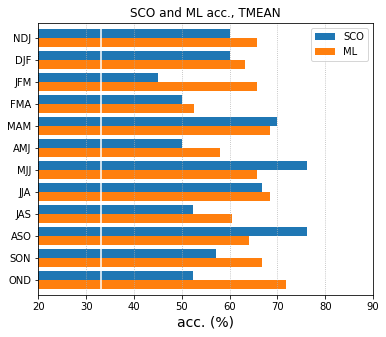

In [241]:
f, ax = plt.subplots(figsize=(6,5))

sco_vs_ML.plot(kind='barh', width=0.85, ax=ax)

ax.set_xlim([20, 90])

plt.gca().invert_yaxis()

ax.axvline(33, color='w')

ax.grid(axis='x',ls=':')

ax.set_title(f'SCO and ML acc., {varname}', fontsize=12, loc='center')

ax.set_xlabel("acc. (%)", fontsize=14)

f.savefig(f"{varname}_acc_ML_SCO.png", dpi=200, bbox_inches='tight')

In [242]:
diff_sco_ml = (sco_vs_ML.ML - sco_vs_ML.SCO)

In [243]:
diff_sco_ml.index = seasons_labels

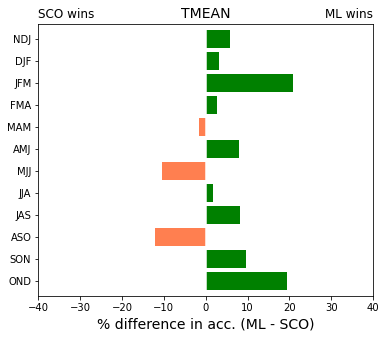

In [244]:
f, ax = plt.subplots(figsize=(6,5))

diff_sco_ml.where(diff_sco_ml > 0).plot(ax=ax, kind='barh', width=0.85, color='g')
diff_sco_ml.where(diff_sco_ml < 0).plot(ax=ax, kind='barh', width=0.85, color='coral') 

ax.axvline(0, color='w')
ax.set_xlim([-40, 40])

plt.gca().invert_yaxis()

ax.set_title('SCO wins', fontsize=12, loc='left')
ax.set_title('ML wins', fontsize=12, loc='right')
ax.set_title(f"{varname}", fontsize=14, loc='center')

ax.set_xlabel("% difference in acc. (ML - SCO)", fontsize=14)

f.savefig(f"{varname}_acc_difference_ML_SCO.png", dpi=200, bbox_inches='tight')